### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1566519454830722482, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14906342346190106286
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14545714928935160324
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2691032843732354999
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

### Load Data (3 Marks)

In [3]:
Data  = pd.read_json('gdrive/My Drive/DATA/Sarcasm_Headlines_Dataset.json',lines=True)

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [5]:
Data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


### Drop `article_link` from dataset (3 Marks)

In [6]:
Data.drop(['article_link'],axis=1,inplace=True)

In [7]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


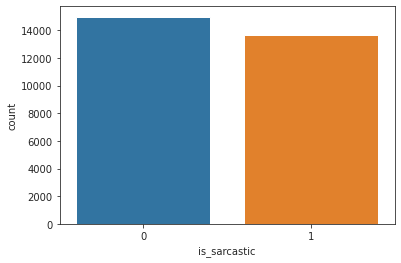

In [8]:
# Verifying the output balance in dataset
sns.set_style("ticks")
sns.countplot(Data.is_sarcastic)

### Get length of each headline and add a column for that (3 Marks)

In [9]:
# Data Cleaning
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
Data['headline'] = Data['headline'].apply(denoise_text)

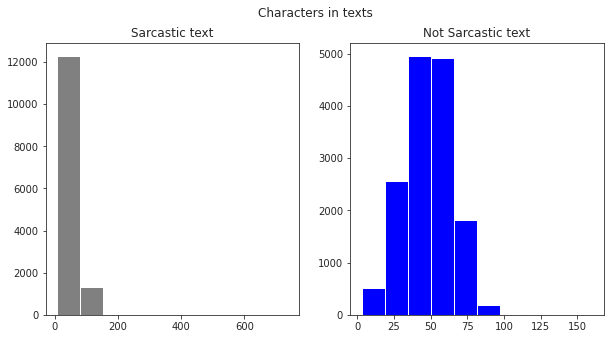

In [11]:
# Number of charecters in text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=Data[Data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='grey')
ax1.set_title('Sarcastic text')
text_len=Data[Data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

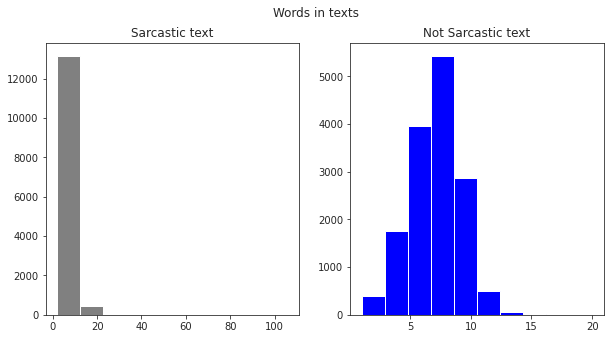

In [12]:
# Number of words in text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len= Data[Data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='grey')
ax1.set_title('Sarcastic text')
text_len=Data[Data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

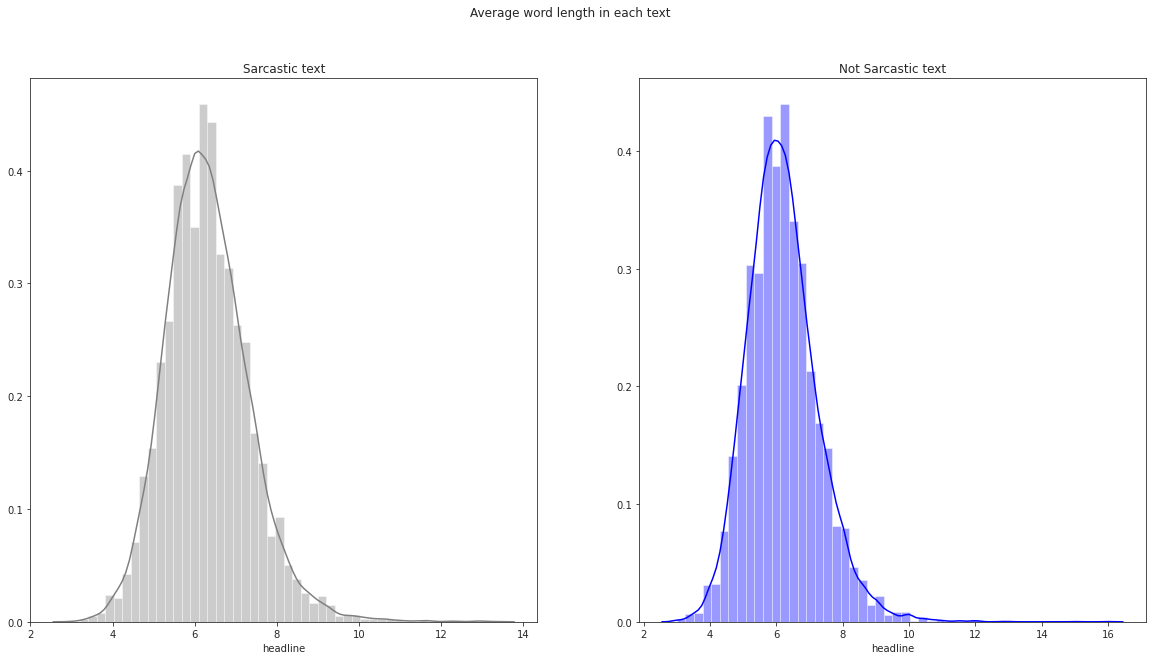

In [13]:
# Average word length in text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word= Data[Data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='grey')
ax1.set_title('Sarcastic text')
word= Data[Data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [14]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [15]:
words = []
for i in Data.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [16]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [18]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)


### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [19]:
x = sequence.pad_sequences(tokenized_train, maxlen = 20)
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [21]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Vocab mapping
- There is no word for 0th index

In [22]:
tokenizer.word_index

{'new': 1,
 'man': 2,
 'trump': 3,
 'one': 4,
 'area': 5,
 'woman': 6,
 'says': 7,
 'donald': 8,
 'report:': 9,
 'u.s.': 10,
 'day': 11,
 'like': 12,
 'get': 13,
 'first': 14,
 'time': 15,
 "trump's": 16,
 'people': 17,
 'still': 18,
 'house': 19,
 'white': 20,
 'make': 21,
 'life': 22,
 'obama': 23,
 'back': 24,
 'women': 25,
 'could': 26,
 'clinton': 27,
 'americans': 28,
 'way': 29,
 'world': 30,
 'family': 31,
 'would': 32,
 'gop': 33,
 'finds': 34,
 'bill': 35,
 'really': 36,
 'black': 37,
 'years': 38,
 '5': 39,
 "can't": 40,
 'school': 41,
 'police': 42,
 'best': 43,
 'nation': 44,
 'know': 45,
 'going': 46,
 'every': 47,
 'american': 48,
 'last': 49,
 'death': 50,
 "'the": 51,
 'say': 52,
 'state': 53,
 'campaign': 54,
 'home': 55,
 'getting': 56,
 'health': 57,
 'things': 58,
 'president': 59,
 'mom': 60,
 'good': 61,
 'may': 62,
 'show': 63,
 'big': 64,
 'gets': 65,
 'hillary': 66,
 'year': 67,
 'need': 68,
 'little': 69,
 'take': 70,
 'video': 71,
 'work': 72,
 'parents': 73

### Load Glove Word Embeddings (3 Marks)

In [23]:
# GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix.
x_train,x_test,y_train,y_test = train_test_split(Data.headline,Data.is_sarcastic, test_size = 0.3 , random_state = 0)

In [24]:
max_features = 35000
maxlen = 200

In [25]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [26]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [27]:
EMBEDDING_FILE = 'gdrive/My Drive/DATA/glove.6B.200d.txt'

In [28]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

### Create embedding matrix

In [29]:
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [30]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [38]:
batch_size = 128
epochs = 2
embed_size = 200

In [39]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))

### Compile the model (3 Marks)

In [40]:
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          5165000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,502,153
Trainable params: 5,502,153
Non-trainable params: 0
_________________________________________________________________


### Fit the model (4 Marks)

In [42]:
model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

Epoch 1/2
139/157 [=========================>....] - ETA: 24s - loss: 0.5230 - acc: 0.7401

InvalidArgumentError: ignored

# Note:
    I am getting this error, when I tried to debug i came across a link which says, this is a bug and can be overcome by changing batchsize . I have tried (8,16,32) batch sizes but still getting the same error. So the model is partially trained but still getting an accuracy of 83% on Test data.

    Link : https://stackoverflow.com/questions/60082554/tensorflow-throwing-distributed-function-error

In [43]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 25s 92ms/step - loss: 0.3921 - acc: 0.8316
Accuracy of the model on Testing Data is -  83.15863013267517


In [44]:
pred = model.predict_classes(X_test)
pred[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [45]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.82      0.87      0.85      4560
    Sarcastic       0.84      0.79      0.81      4026

     accuracy                           0.83      8586
    macro avg       0.83      0.83      0.83      8586
 weighted avg       0.83      0.83      0.83      8586



In [46]:
cm = confusion_matrix(y_test,pred)
cm

array([[3968,  592],
       [ 854, 3172]])

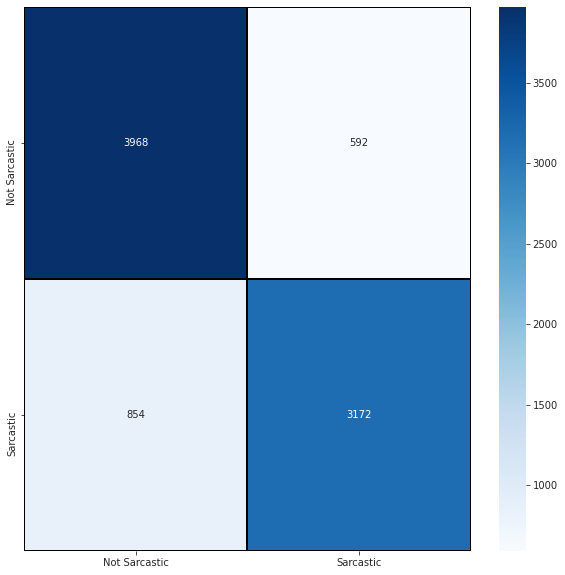

In [47]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])